Files are coming from 

https://topotools.cr.usgs.gov/gmted_viewer/viewer.htm

Thanks to the USGS for providing the data.

Also thanks to Adam Symington.
https://towardsdatascience.com/creating-beautiful-topography-maps-with-python-efced5507aa3

In [1]:
import rasterio
from rasterio.merge import merge
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
from rasterio import mask as msk
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib import colors



Combine the data into a single dataframe because the platform gives squares that might not contain everything we want.

In [2]:
def combine_tif_files(input_files, output_file):
    # Open the input TIF files
    src_files_to_merge = []
    for file in input_files:
        src = rasterio.open(file)
        src_files_to_merge.append(src)

    # Merge the TIF files
    merged, merged_transform = merge(src_files_to_merge)

    # Update the metadata for the merged TIF
    merged_meta = src.meta.copy()
    merged_meta.update({
        "driver": "GTiff",
        "height": merged.shape[1],
        "width": merged.shape[2],
        "transform": merged_transform
    })

    # Write the merged TIF to the output file
    with rasterio.open(output_file, "w", **merged_meta) as dest:
        dest.write(merged)

    # Close the source files
    for src in src_files_to_merge:
        src.close()

    print("TIF files merged successfully.")

# Example usage
# input_files = ["data/30N000E_20101117_gmted_mea300.tif", "data/30N030E_20101117_gmted_mea300.tif", "data/30N030W_20101117_gmted_mea300.tif", "data/50N000E_20101117_gmted_mea300.tif", "data/50N030E_20101117_gmted_mea300.tif", "data/50N030W_20101117_gmted_mea300.tif"]
# output_file = "output/merged.tif"
input_files = ["data/30S090E_20101117_gmted_mea300.tif", "data/30S120E_20101117_gmted_mea300.tif", "data/30S150E_20101117_gmted_mea300.tif", "data/50S090E_20101117_gmted_mea300.tif", "data/50S120E_20101117_gmted_mea300.tif", "data/50S150E_20101117_gmted_mea300.tif"]
output_file = "output/australia_merged.tif"


combine_tif_files(input_files, output_file)

TIF files merged successfully.


Raster so that the nodata fields are replaced with values close to the surrounding values.

In [3]:
def clip_raster(gdf, img):
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)], crop=True)
    # print(np.amin(clipped_array), np.amax(clipped_array))
    nodata_value = -1000
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)], crop=True, nodata=nodata_value)
    # print(np.amin(clipped_array), np.amax(clipped_array))
    clipped_array[0] = clipped_array[0] + abs(np.amin(clipped_array))
    value_range = np.amax(clipped_array) + abs(np.amin(clipped_array))
    return clipped_array, value_range

Check the file and see if it's correct.

(1, 4800, 10800)
(4800, 10800)


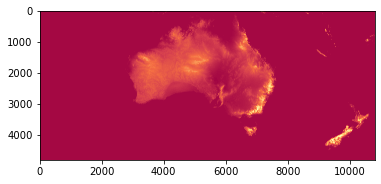

In [4]:
file = rasterio.open('output/australia_merged.tif')
dataset = file.read()
print(dataset.shape)
print(dataset[0].shape);
plt.imshow(dataset[0], cmap='Spectral')
plt.show()
# plt.savefig('output/test2.png', dpi=600)

Clip the file to only contain the area we want, using https://www.naturalearthdata.com/ 

Export it as a grayscale image.

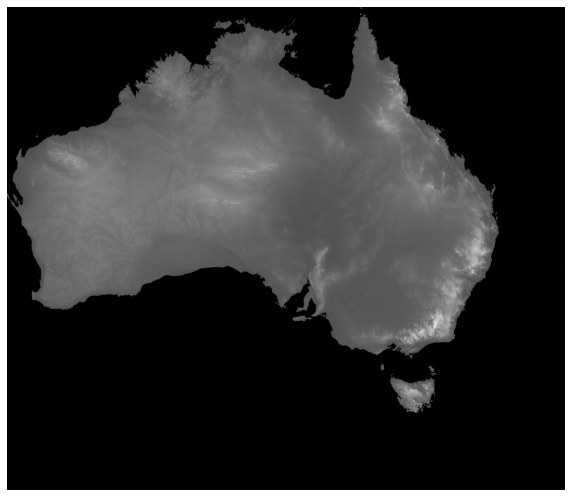

In [6]:

df = gpd.read_file('data/10m_cultural/ne_10m_admin_0_countries.shp')
usedCountry='Australia'
country = df.loc[df['ADMIN'] == usedCountry]

clipped_array, clipped_transform = msk.mask(file, [mapping(country.iloc[0].geometry)], crop=True)

country_topo, value_range = clip_raster(country, file)
plt.figure(figsize=(10,10))
plt.imshow(country_topo[0], cmap='gray')
# plt.colorbar(c)
plt.axis('off')
# plt.show()
plt.savefig('output/country_topography.png', dpi=600)